In [139]:
import math

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load Data
---

In [140]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [141]:
# Set working directory to default
%cd /content/
!rm -rf dataset
!mkdir dataset
# 你在你的google drive創一個資料夾叫Data，然後把資料放進去，應該就可以跑這兩行了
!cp "/content/drive/MyDrive/Data/Indian_pines_corrected.mat" "dataset"
!cp "/content/drive/MyDrive/Data/Indian_pines_gt.mat" "dataset"
!cp "/content/drive/MyDrive/Data/6XXvuUX.jpg" "dataset"

/content
cp: cannot stat '/content/drive/MyDrive/Data/6XXvuUX.jpg': No such file or directory


In [142]:
# img = mpimg.imread("./dataset/6XXvuUX.jpg") 
# i=0
# while i != 10:
#   i+=1
#   plt.imshow(img) 
#   plt.axis('off')
#   plt.show()

# Main
---

In [143]:
# Load data: [145, 145, 200]
x_data = sio.loadmat("./dataset/Indian_pines_corrected.mat")['indian_pines_corrected']
y_data = sio.loadmat("./dataset/Indian_pines_gt.mat")['indian_pines_gt']

pixels_dict = {
    "x_1": (0, 0),
    "x_2": (135, 100),
    "x_3": (1, 1)
}

x_1 = x_data[pixels_dict["x_1"][0], pixels_dict["x_1"][1], :]  # Class 3
x_2 = x_data[pixels_dict["x_2"][0], pixels_dict["x_2"][1], :]  # Class 14
x_3 = x_data[pixels_dict["x_3"][0], pixels_dict["x_3"][1], :]  # Class 3
x_rand = abs(np.random.randn(200, ) + 0.1)  # Random vector for comparison


y_1 = y_data[pixels_dict["x_1"][0], pixels_dict["x_1"][1]]
y_2 = y_data[pixels_dict["x_2"][0], pixels_dict["x_2"][1]]
y_3 = y_data[pixels_dict["x_3"][0], pixels_dict["x_3"][1]]

print(f"Class of pixel 1: {y_1}")
print(f"Class of pixel 2: {y_2}")
print(f"Class of pixel 3: {y_3}")

Class of pixel 1: 3
Class of pixel 2: 14
Class of pixel 3: 3


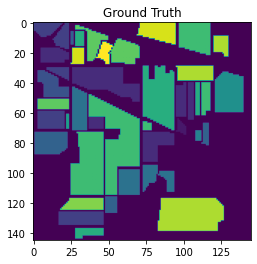

In [144]:
plt.title("Ground Truth")
plt.imshow(y_data)
plt.show()

### Fetch Spectral Signatures for Each Classes
---

In [208]:
def get_spectral_signatures(x_data, y_data):
    h, w, n_bands = x_data.shape[0], x_data.shape[1], x_data.shape[2]
    spectral_dict = {}
    classes = np.unique(y_data)

    for pix_class in classes:
        spectral_dict[pix_class] = []

    for row in range(h):
        for col in range(w):
            cur_pixel = x_data[row, col, :]
            cur_label = y_data[row, col]

            spectral_dict[cur_label].append(cur_pixel)

    for key, _ in spectral_dict.items():
        spectral_dict[key] = np.mean(np.array(spectral_dict[key]), axis=0) # []
        
    return spectral_dict


In [ ]:
spectral_dict = get_spectral_signatures(x_data, y_data)

## Task 3
---

### Euclidean Distance
---

In [145]:
# L2 Distance  (Euclidean Distance)
dist_12 = np.linalg.norm(x_1 - x_2)
dist_13 = np.linalg.norm(x_1 - x_3)
dist_rand = np.linalg.norm(x_1 - x_rand)

print(
    f"The euclidean distance between pixel 1 and pixel 2: {dist_12:.4f} (different classes)")
print(
    f"The euclidean distance between pixel 1 and pixel 3: {dist_13:.4f} (same classes)")
print(
    f"The euclidean distance between pixel 1 and random vector: {dist_rand:.4f} (random vector)")

The euclidean distance between pixel 1 and pixel 2: 516762.0335 (different classes)
The euclidean distance between pixel 1 and pixel 3: 889694.9357 (same classes)
The euclidean distance between pixel 1 and random vector: 42670.3989 (random vector)


### Spectral Angles Mappers
---

In [146]:
def SAM(pixel_1, pixel_2):
    """Calculate spectral angles mapper (SAM) for two pixels.

    Args:
        pixel_1 (ndarray): [n_bands, 1]
        pixel_2 (ndarray): [n_bands, 1]

    Returns:
        float: SAM value
    """
    numerator = 0
    denominator_l = 0
    denominator_r = 0

    n_bands = len(pixel_1)
    for i in range(n_bands):
        rx, ry = float(pixel_1[i]), float(pixel_2[i])

        numerator += rx * ry
        denominator_l += rx * rx
        denominator_r += ry * ry

    res = math.acos(numerator / (math.sqrt(denominator_l)
                    * math.sqrt(denominator_r)))

    return res * 180 / math.pi

In [147]:
# Spectral Angles Mappers
sam_12 = SAM(x_1, x_2)
sam_13 = SAM(x_1, x_3)
sam_rand = SAM(x_1, x_rand)

print(
    f"The SAM value between pixel 1 and pixel 2: {sam_12:.4f} (different classes)")
print(
    f"The SAM value between pixel 1 and pixel 3: {sam_13:.4f} (same classes)")
print(
    f"The SAM value between pixel 1 and random vector: {sam_rand:.4f} (random vector)")

The SAM value between pixel 1 and pixel 2: 17.4524 (different classes)
The SAM value between pixel 1 and pixel 3: 1.7914 (same classes)
The SAM value between pixel 1 and random vector: 42.8811 (random vector)


### Spectral Information Divergence
---

In [148]:
def SID(pixel_1, pixel_2):
    """Calculate spectral information divergence (SID)

    Args:
        pixel_1 (ndarray): [n_bands, 1]
        pixel_2 (ndarray): [n_bands, 1]

    Returns:
        float: SID value
    """
    sid_f = 0
    sid_r = 0

    n_bands = len(pixel_1)
    for i in range(n_bands):
        rx, ry = float(pixel_1[i]), float(pixel_2[i])
        sid_f += _KLDivergence(rx, ry)
        sid_r += _KLDivergence(ry, rx)

    return sid_f + sid_r


# Kullback-Leibler divergence (KLD) (preprocessing part)
def _KLDivergence(rx, ry):
    return(rx*np.log(rx/ry))

In [149]:
# Spectral Information Divergence (SID)
sid_12 = SID(x_1, x_2)
sid_13 = SID(x_1, x_3)
sid_rand = SID(x_1, x_rand)

print(
    f"The SID value between pixel 1 and pixel 2: {sid_12:.4f} (different classes)")
print(
    f"The SID value between pixel 1 and pixel 3: {sid_13:.4f} (same classes)")
print(
    f"The SID value between pixel 1 and random vector: {sid_rand:.4f} (random vector)")

The SID value between pixel 1 and pixel 2: 46495.3045 (different classes)
The SID value between pixel 1 and pixel 3: 1488.1061 (same classes)
The SID value between pixel 1 and random vector: 4605210.4167 (random vector)


### Mahalanobis Distance
---

In [150]:
def mahal_dist(rx, ry):
    n_bands = len(rx)
    
    x_BA = np.array((ry - rx).reshape(n_bands, 1))  # [n_bands, 1]
    data = np.array([rx, ry])  # [2,n_bands]
    x_BA_transpose = np.transpose(x_BA)  # [1, n_bands]
    
    x_covariance = np.cov(data, rowvar=False)  # [n_bands, n_bands]
    inv_cov = np.linalg.pinv(x_covariance)  # [n_bands, n_bands]

    res = np.matmul(x_BA_transpose, inv_cov)
    res = np.matmul(res, x_BA)
    return math.sqrt(res)

In [151]:
# Mahalanobis distance
md_12 = mahal_dist(x_1, x_2)
md_13 = mahal_dist(x_1, x_3)
md_rand = mahal_dist(x_1, x_rand)

print(
    f"The Mahalanobis distance value between pixel 1 and pixel 2: {md_12:.4f} (different classes)"
)
print(
    f"The Mahalanobis distance value between pixel 1 and pixel 3: {md_13:.4f} (same classes)"
)
print(
    f"The Mahalanobis distance value between pixel 1 and random vector: {md_rand:.4f} (random vector)"
)

The Mahalanobis distance value between pixel 1 and pixel 2: 36.4130 (different classes)
The Mahalanobis distance value between pixel 1 and pixel 3: 15.7220 (same classes)
The Mahalanobis distance value between pixel 1 and random vector: 1.4142 (random vector)


## Task 4
---
Find or propose a method different from the above to measure the spectral similarity and compare with the others.

### Pearson Correlation Coefficient
---
$$\rho_{X, Y} = \frac{cov(X, Y)}{σ_Xσ_Y}$$

$\rho_{X, Y} \in [-1, 1]$, $-1$ means $X, Y$ are very different from each other. 

$1$ means $X, Y$ are identical.

In [152]:
def PCC(pixel_1, pixel_2):
    pix_1_diff = pixel_1 - np.mean(pixel_1)
    pix_2_diff = pixel_2 - np.mean(pixel_2)
    numerator = np.sum(pix_1_diff * pix_2_diff)
    denominator = math.sqrt(np.sum(np.power(pix_1_diff, 2))) * math.sqrt(np.sum(np.power(pix_2_diff, 2)))
    
    return numerator / denominator

In [153]:
pcc_11 = PCC(x_1, x_1)
pcc_12 = PCC(x_1, x_2)
pcc_13 = PCC(x_1, x_3)
pcc_rand = PCC(x_1, x_rand)

print(f"The PCC value between pixel 1 and pixel 1: {pcc_11:.4f} (same points)")
print(f"The PCC value between pixel 1 and pixel 2: {pcc_12:.4f} (different classes)")
print(f"The PCC value between pixel 1 and pixel 3: {pcc_13:.4f} (same classes)")
print(f"The PCC value between pixel 1 and random vector: {pcc_rand:.4f} (with random vector)")

The PCC value between pixel 1 and pixel 1: 1.0000 (same points)
The PCC value between pixel 1 and pixel 2: 0.8574 (different classes)
The PCC value between pixel 1 and pixel 3: 0.9982 (same classes)
The PCC value between pixel 1 and random vector: 0.1026 (with random vector)


## Task 5
---
Implement CEM with your own codes and show its results on the data set you picked

### Constrained Energy Minimization
---

In [296]:
def CEM(x_data, d):
    """ Compute constrained energy minimization filter with given 
        spectral signature.

    Args:
        x_data (ndarray): [height, width, n_bands]
        d (ndarray): [n_bands, 1], target spectral signature

    Returns:
        ndarray: CEM filter for target spectrum.
    """
    h, w, n_bands = x_data.shape[0], x_data.shape[1], x_data.shape[2]

    # Correlation matrix
    R = np.zeros((n_bands, n_bands))

    for row in range(h):
        for col in range(w):
            cur_pixel = x_data[row, col, :].reshape(n_bands, 1)
            R = np.add(R, np.matmul(cur_pixel, cur_pixel.T))
    R = R / (h*w)  # [n_bands, n_bands]

    numerator = np.matmul(np.linalg.inv(R), d)  # [n_bands, 1]
    denominator = np.matmul(np.matmul(d.T, np.linalg.inv(R)), d)  # Scalar

    return numerator / denominator  # [n_bands ,1] filter

def apply_cem(x_data, y_data, filter):
    h, w, n_bands = x_data.shape[0], x_data.shape[1], x_data.shape[2]

    pred = np.zeros((h, w))
    for row in range(h):
        for col in range(w):
            cur_pixel = x_data[row, col, :].reshape(n_bands, 1)

            if y_data[row, col] == 0: 
                pred[row, col] = 0 # Ignore backgrounds to imporve visibility
            else:
                pred[row, col] = abs(np.matmul(filter, cur_pixel))

    return pred

In [297]:
cem_filter = CEM(x_data, x_1)

print(f"The value for CEM filter applies on pixel 1: {np.matmul(cem_filter, x_1):.4f} (pixel 1 equals d)")
print(f"The value for CEM filter applies on pixel 2: {np.matmul(cem_filter, x_2):.4f} (different class with d)")
print(f"The value for CEM filter applies on pixel 3: {np.matmul(cem_filter, x_3):.4f} (same class with d)")
print(f"The value for CEM filter applies on random vector: {np.matmul(cem_filter, x_rand):.4f} (random vector)")

The value for CEM filter applies on pixel 1: 1.0000 (pixel 1 equals d)
The value for CEM filter applies on pixel 2: -0.9579 (different class with d)
The value for CEM filter applies on pixel 3: 0.6125 (same class with d)
The value for CEM filter applies on random vector: -0.0006 (random vector)


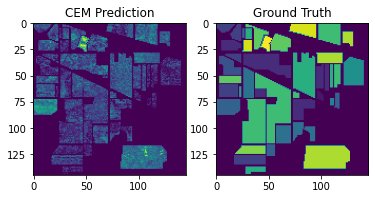

In [298]:
cem_pred = apply_cem(x_data, y_data, cem_filter)

# cem_pred[130:140, 95:105] = 200
cem_fig = plt.figure()

cem_fig.add_subplot(1, 2, 1)
plt.imshow(cem_pred)
plt.title("CEM Prediction")

cem_fig.add_subplot(1, 2, 2)
plt.imshow(y_data)
plt.title("Ground Truth")

plt.show()

## Task 6
---
Implement OSP with your own codes and show its results on the data set you picked

### Orthogoanl Subspace Projection
---

In [304]:
def OSP(target, spectrals):
    """ Compute orthogonal subspace projection
    """
    n_classes = len(spectrals.keys()) - 1 # Background doesn't count
    n_bands = spectrals[0].shape[0]

    # Find U
    U = np.zeros((1, n_bands)) # Initialize
    
    for key, spec_sig in spectrals.items():
        if key != target and key != 0:
            U = np.row_stack((U, spec_sig))

    # Drop first column of U
    U = U[1:, :].T # [n_classes-1, n_bands]
    
    # Find P = (I - UU^sharp)
    I = np.identity(n_bands) # Target class doesn't count
    P = I - np.matmul(U, np.linalg.pinv(U))
    return P

def apply_osp(x_data, y_data, spectrals, target, P):
    h, w, n_bands = x_data.shape[0], x_data.shape[1], x_data.shape[2]
    d = spectrals[target]

    pred = np.zeros((h, w))
    for row in range(h):
        for col in range(w):
            cur_pixel = x_data[row, col, :].reshape(n_bands, 1)

            if y_data[row, col] == 0: 
                pred[row, col] = 0 # Ignore backgrounds to imporve visibility
            else:
                term = np.matmul(d.T, P)
                pred[row, col] = abs(np.matmul(term, cur_pixel))

    return pred

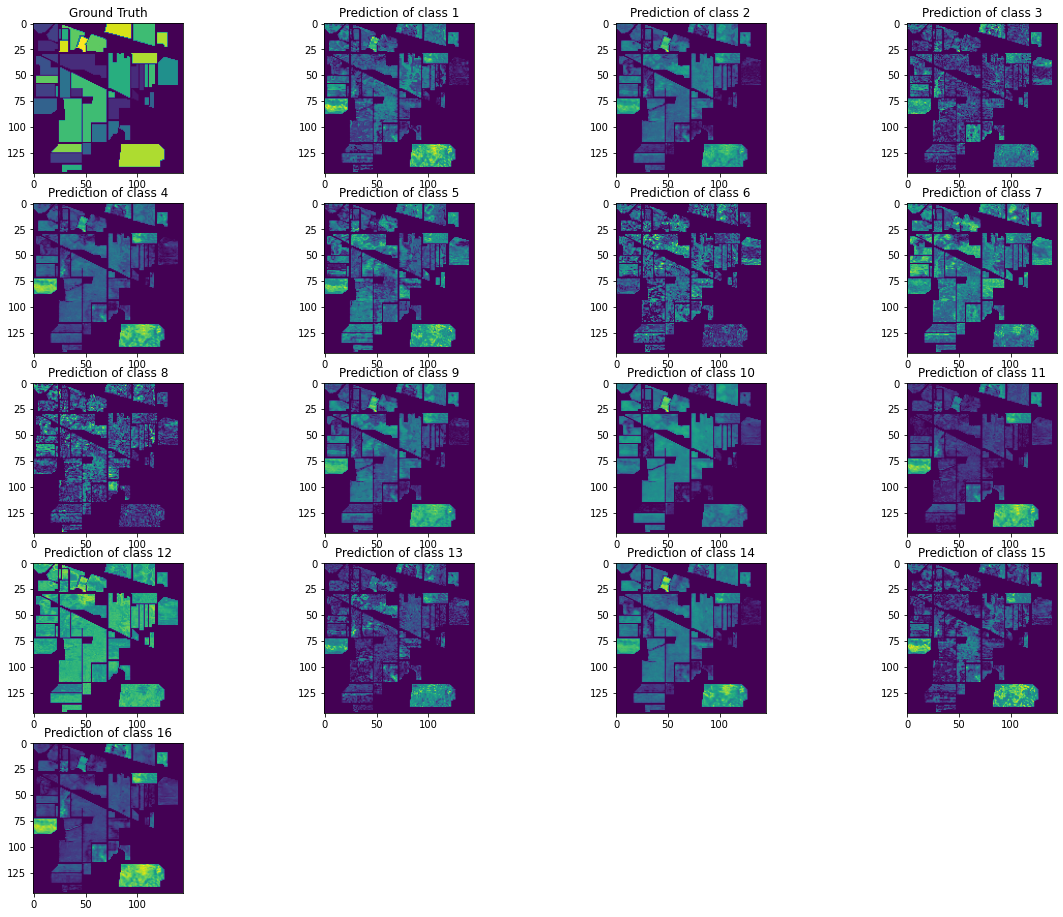

In [317]:
fig_h, fig_w = 4, 5
osp_fig = plt.figure(figsize=(20, 16))

target_class = 0
for row in range(1, fig_h + 1):
    for col in range(1, fig_w + 1):
        target_class += 1
        if target_class-1 > 16:
            break

        osp_fig.add_subplot(fig_w, fig_h, target_class)
        
        if target_class == 1: # Plot ground truth
            plt.imshow(y_data)
            plt.title("Ground Truth")
        else:
            osp_filter = OSP(target_class, spectral_dict)
            osp_pred = apply_osp(x_data, y_data, spectral_dict, target_class-1, osp_filter)

            plt.imshow(osp_pred)
            plt.title(f"Prediction of class {target_class-1}")

plt.show()